In [ ]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
import sys
from tqdm import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
device

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq kagglecatsanddogs_5340.zip
!rm -rf PerImages/Cat/666.jpg PetImagesy/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2023-02-09 03:58:43--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.216.167, 2600:1408:c400:168a::317f, 2600:1408:c400:1680::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.216.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  75.7MB/s    in 9.1s    

2023-02-09 03:58:53 (86.4 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

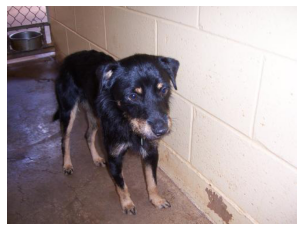

In [ ]:
file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file))

In [ ]:
!pip install pytorch-lightning
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(512, 2)

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_data_loader, criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
fit(model, 5, train_dataloader, test_dataloader, optimizer, criterion, device=device)

Train Epoch: 0

Loss: 0.6821 Accuracy: 58.5938:  95%|█████████▍| 75/79 [38:06<02:01, 30.48s/it]


UnidentifiedImageError: ignored

In [ ]:
model_full = resnet18(pretrained=False)
model_full.fc = nn.Linear(512, 2)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-4
)  # YOUR CODE. It must optimize across all parameters

In [ ]:
fit(
    model_full,
    5,
    train_dataloader,
    test_dataloader,
    optimizer,
    criterion,
    device=device,
)